In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pandas as pd
import numpy as np
jul_22=pd.read_excel(r'/content/drive/MyDrive/timeSeries_project/data/jul-22.xlsx')
nov_22=pd.read_excel(r'/content/drive/MyDrive/timeSeries_project/data/nov-22.xlsx')
feb_23=pd.read_excel(r'/content/drive/MyDrive/timeSeries_project/data/feb-23.xlsx')

## Data Preprocessing

In [ ]:
dfs=[jul_22,nov_22,feb_23]


In [ ]:
indx=["jul_22","nov_22","feb_23"]
for i,df in zip(indx,dfs):
    print(f"---------{i}--------\n")
    print(df.shape)
    print(df.dtypes,"\n")
    print(df.describe())
    print(f'\n{df.isnull().sum()}\n')


NameError: name 'nov_22' is not defined

#### Drop Columns

In [ ]:
#calculate missing values purcentage in usage_op1
for df in dfs:
    na_pourcentage = []
    na_op1 = (df['usage_op1'].isnull().sum() / len(df)) * 100
    na_op2 = (df['usage_op2'].isnull().sum() / len(df)) * 100
    na_op3 = (df['usage_op3'].isnull().sum() / len(df)) * 100
    na_pourcentage.append(na_op1)
    na_pourcentage.append(na_op2)
    na_pourcentage.append(na_op3)
    print(na_pourcentage)

[99.46426629976344, 92.54921514450564, 40.51556401998973]
[99.56556746896423, 94.85913923221442, 36.481869834005835]
[99.60556614974993, 95.05900766380023, 39.25808656856043]


In [3]:
def drop_columns(data, columns_to_drop):
    for df in data:
        df.drop(columns=columns_to_drop, inplace=True)
columns_to_drop = ['usage_op1', 'usage_op2', 'total_rev_sos']
drop_columns(dfs, columns_to_drop)

In [4]:
#drop dupliactes
def drop_duplicates(data):
    for df in data:
        df.drop_duplicates(inplace=True)
drop_duplicates(dfs)

### Categorical Data

In [ ]:
jul_22.select_dtypes(include=['object']).columns

Index(['activation_date', 'entity_code', 'entity_type_name'], dtype='object')

In [5]:
# Dictionnaire de correspondance
import re

gouvernorats_map = {
    "TRA": "Agence Trade",
    "ARI": "Ariana",
    "BEJ": "Béja",
    "BEN": "Ben Arous",
    "AZUR": "Ben Arous",
    "FOUCH": "Ben Arous",
    "MJ": "Ben Arous",
    "ZAR": "Zarsis",
    "JER": "Djerba",
    "BIZ": "Bizerte",
    "KEF": "El Kef",
    "GAB": "Gabès",
    "GAF": "Gafsa",
    "JEN": "Jendouba",
    "KAI": "Kairouan",
    "KAS": "Kasserine",
    "KEB": "Kébili",
    "MAH": "Mahdia",
    "MAN": "Manouba",
    "MED": "Medenine",
    "MEDMED": "Medenine",
    "MON": "Monastir",
    "MOK": "Monastir",
    "NAB": "Nabeul",
    "HAM": "Nabeul",
    "KLB": "Nabeul",
    "SFA": "Sfax",
    "SFXSFX": "Sfax",
    "SFX": "Sfax",
    "SID": "Sidi Bouzid",
    "SIL": "Siliana",
    "SOU": "Sousse",
    "SAH": "Sousse",
    "TAT": "Tataouine",
    "TOZ": "Tozeur",
    "TOZTOZ": "Tozeur",
    "TUN": "Tunis",
    "LAFLAF": "Tunis",
    "LAC": "Tunis",
    "ELM": "Tunis",
    "AOU": "Tunis",
    "MAR": "Tunis",
    "HBOURG": "Tunis",
    "ZAG": "Zaghouan"
}

# Fonction pour mapper le gouvernorat
def map_gouvernorat(code):
    if code == "NULL" or pd.isna(code):  # Garder les valeurs nulles ou "NULL" comme tel
        return code

    # Chercher tous les préfixes du dictionnaire dans le code
    for prefix, gouvernorat in gouvernorats_map.items():
        if prefix in code:  # Si un préfixe est trouvé
            return gouvernorat  # Retourner le gouvernorat correspondant

    return code  # Garder la valeur d'origine si aucun préfixe n'est trouvé

# Appliquer la fonction de mapping
for df in dfs:
    df['gouvernorat'] = df['entity_code'].apply(map_gouvernorat)
    df.drop(columns=['entity_code'], inplace=True)

In [6]:
'''DIRECT : AGENCE TRADE, TRAVEL RETAIL, FRANCHISE, BOUTIQUE, LAB2.0, AUTRES BOUTIQUES
INDIRECT : INDIRECT, CONVENTION, PRO'''
#map entity_type_name to DIRECT ou INDIRECT
def map_entity_type_name(entity_type_name):
    if entity_type_name in ['AGENCE TRADE', 'TRAVEL RETAIL', 'FRANCHISE', 'BOUTIQUE', 'LAB2.0', 'AUTRES BOUTIQUES']:
        return 'DIRECT'
    else:
        return 'INDIRECT'
for df in [jul_22]:
    df['entity_type_name'] = df['entity_type_name'].apply(map_entity_type_name)

In [7]:
#drop nan values for categorical data
for df in dfs:
    df['activation_date']=df['activation_date'].fillna(method="bfill")
    df['gouvernorat']=df['gouvernorat'].fillna(df['gouvernorat'].mode()[0])
    df['entity_type_name']=df['entity_type_name'].fillna(df['entity_type_name'].mode()[0])

<ipython-input-7-78100735e6e8>:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['activation_date']=df['activation_date'].fillna(method="bfill")


### Numerical Data

In [58]:
numerical_cols=df.select_dtypes(include=['int64', 'float64','datetime']).columns
numerical_cols

Index(['co_id', 'total_nb_recharge', 'total_rechage', 'total_u_data',
       'total_rev_option', 'total_u_out', 'total_u_in', 'usage_op3',
       'nb_cont_out', 'nb_cont_in', 'nb_cell_visite_out', 'nb_cell_visite_in',
       'nbr_contrat', 'nbr_actif', 'flag_churn'],
      dtype='object')

#### Data Imputing

In [16]:
# Calculate percentage of missing values
missing_percentage = jul_22.isna().mean() * 100
print("\nPercentage of Missing Values:\n", missing_percentage)


Percentage of Missing Values:
 co_id                  0.000375
activation_date        0.000375
total_nb_recharge     10.778032
total_rechage         10.778032
total_u_data          17.720076
total_rev_option      40.836104
total_rev_sos         99.847415
total_u_out            7.548259
total_u_in            29.886367
usage_op1             99.464266
usage_op2             92.549215
usage_op3             40.515564
nb_cont_out            8.004139
nb_cont_in             4.975688
nb_cell_visite_out     8.004139
nb_cell_visite_in      4.975688
entity_code            3.083562
entity_type_name       3.083562
nbr_contrat            0.000375
nbr_actif              0.000000
flag_churn             0.000375
dtype: float64


In [ ]:
#convert activation_date to date object
for df in dfs:
    df['activation_date'] = pd.to_datetime(df['activation_date'], format='%Y-%m-%d %H:%M:%S')

NameError: name 'nov_22' is not defined

In [ ]:
#check what co_id having multiple activation_date
pd.concat(g for _, g in jul_22.groupby("co_id") if len(g) > 1)

,co_id,activation_date,total_nb_recharge,total_rechage,total_u_data,total_rev_option,total_u_out,total_u_in,usage_op3,nb_cont_out,nb_cont_in,nb_cell_visite_out,nb_cell_visite_in,entity_type_name,nbr_contrat,nbr_actif,flag_churn,gouvernorat
123203,33213475.0,2022-07-19 21:57:39,2.0,5.386,6.123520e+06,3.277311,174.083,31.800,10.017,24.0,23.0,18.0,25.0,DIRECT,53.0,1.0,1.0,Tunis
218532,33213475.0,2022-07-06 16:27:32,2.0,5.386,6.123520e+06,3.277311,174.083,31.800,10.017,24.0,23.0,18.0,25.0,DIRECT,53.0,0.0,1.0,Tunis
48321,33213496.0,2022-07-15 16:13:01,18.0,41.386,1.279247e+07,32.798319,142.799,81.251,29.017,18.0,19.0,14.0,29.0,DIRECT,40.0,2.0,0.0,Tunis
218533,33213496.0,2022-07-02 08:21:52,18.0,41.386,1.279247e+07,32.798319,142.799,81.251,29.017,18.0,19.0,14.0,29.0,DIRECT,40.0,12.0,0.0,Tunis
64993,33223120.0,2022-07-14 11:09:42,3.0,6.386,1.049519e+06,NaN,283.201,74.483,23.183,51.0,32.0,81.0,61.0,DIRECT,2.0,0.0,1.0,Tunis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222462,38499180.0,2022-07-20 09:40:22,2.0,2.000,8.173251e+04,NaN,23.067,12.267,2.200,10.0,12.0,5.0,10.0,DIRECT,1.0,2.0,0.0,Nabeul
43736,38501070.0,2022-07-30 13:09:36,5.0,5.000,1.456656e+06,3.697479,47.234,10.284,33.850,17.0,20.0,20.0,26.0,DIRECT,2.0,2.0,0.0,Ben Arous
204617,38501070.0,2022-07-20 12:19:38,5.0,5.000,1.456656e+06,3.697479,47.234,10.284,33.850,17.0,20.0,20.0,26.0,DIRECT,2.0,0.0,0.0,Ben Arous
64181,38809473.0,2022-07-30 16:23:50,NaN,NaN,NaN,NaN,0.000,0.100,NaN,1.0,4.0,0.0,10.0,INDIRECT,2.0,5.0,0.0,Nabeul


In [17]:
# Ensure activation_date is in datetime format
df = jul_22.copy()
df['activation_date'] = pd.to_datetime(df['activation_date'], format='%Y-%m-%d %H:%M:%S')

# Extract the time part for the index (hour:minute:second)
df['time'] = df['activation_date'].dt.strftime('%H:%M:%S')  # Format as HH:MM:SS

# Extract the date part for the columns (major intervals)
df['date'] = df['activation_date'].dt.date  # Extract date object

# Create a custom time range to cover the full 24-hour cycle
time_range = pd.timedelta_range(start='00:00:00', end='23:59:59', freq='S')

# Pivot the data: Index will be custom time range, and columns will be days
reshaped_data = df.pivot_table(
    index='time',  # Time will be the index
    columns='date',  # Days will be the columns
    values='total_nb_recharge'  # Numerical columns for aggregation
     # Aggregation function (you can change this)
).reindex(index=[pd.to_datetime(t.total_seconds(), unit='s').strftime('%H:%M:%S') for t in time_range],
          fill_value="NaN")


# Reset the index if you want to display the time column as normal
reshaped_data = reshaped_data.reset_index()

# Display the reshaped data
reshaped_data.head()

<ipython-input-17-09151cb09d34>:12: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  time_range = pd.timedelta_range(start='00:00:00', end='23:59:59', freq='S')


date,time,2022-07-01,2022-07-02,2022-07-03,2022-07-04,2022-07-05,2022-07-06,2022-07-07,2022-07-08,2022-07-09,...,2022-07-22,2022-07-23,2022-07-24,2022-07-25,2022-07-26,2022-07-27,2022-07-28,2022-07-29,2022-07-30,2022-07-31
0,00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00:00:01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00:00:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00:00:03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00:00:04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Daily max values

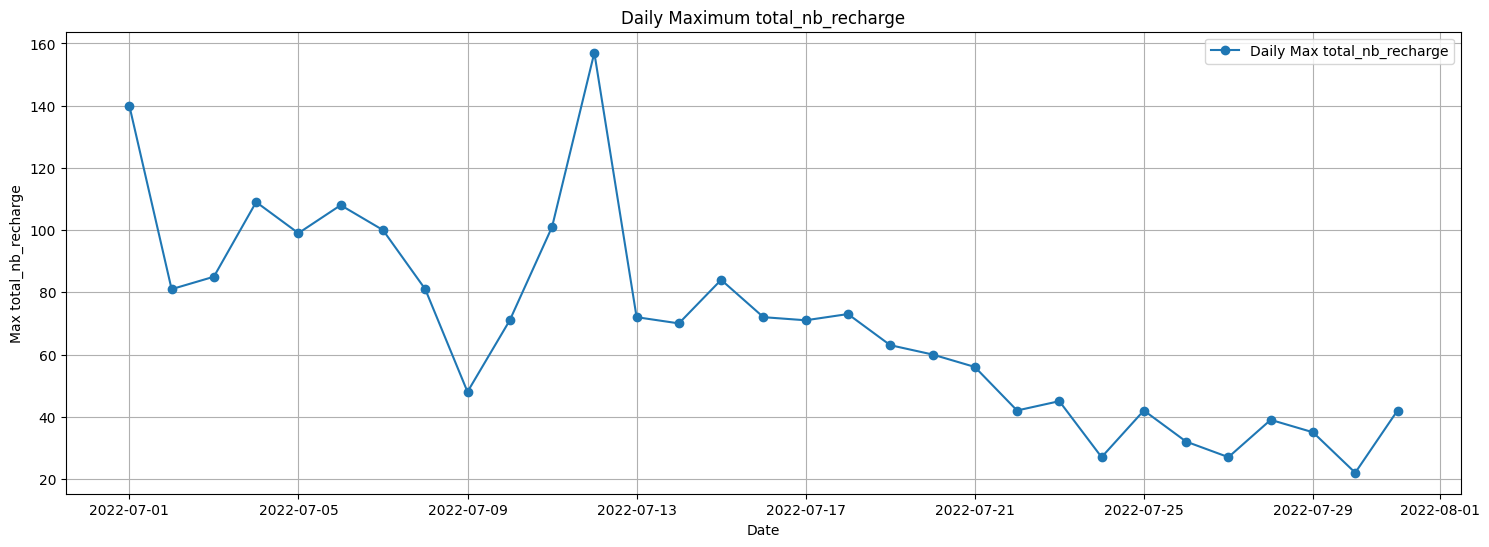

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'time' column to datetime objects
reshaped_data['time_datetime'] = pd.to_datetime(reshaped_data['time'], format='%H:%M:%S')

# Convert numeric columns to numeric type, coercing errors to NaN
for col in reshaped_data.columns:
    if col != 'time' and col != 'time_datetime':  # Exclude non-numeric columns
        reshaped_data[col] = pd.to_numeric(reshaped_data[col], errors='coerce')

daily_max_data = reshaped_data.set_index('time_datetime').mean(axis=1)

# Drop non-date columns
daily_max_data = daily_max_data.drop(['time'], errors='ignore')  # Drop 'time' if it's still present

# Convert index to datetime for plotting
daily_max_data.index = pd.to_datetime(daily_max_data.index)

# Plot the data
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(daily_max_data.index, daily_max_data.values, marker='o', linestyle='-', label='Daily Max total_nb_recharge')

# Add plot details
plt.xlabel('Date')
plt.ylabel('Max total_nb_recharge')
plt.title('Daily Maximum total_nb_recharge')
plt.grid(True)
plt.legend()
plt.show()

Try to plot each column in order to understand how to fill its missing values

In [36]:
col='nb_cell_visite_in'

#### using Mean and Median

In [37]:
df_median = jul_22[['activation_date', 'co_id', col]]

# Convert activation_date to datetime format
df_median['activation_date'] = pd.to_datetime(df_median['activation_date'], format='%Y-%m-%d %H:%M:%S')
df_median[col]=df_median[col].fillna(df_median[col].median())
# Set start and end dates
start_date = pd.to_datetime('2022-07-01 00:00:00')
end_date = pd.to_datetime('2022-07-30 23:59:59')

# Filter data for the specified range
zoom_range_median = df_median[(df_median['activation_date'] >= start_date) & (df_median['activation_date'] <= end_date)]

# Resample data to 12-hour intervals
resampled_data_median = zoom_range_median.resample('12H', on='activation_date').mean()

<ipython-input-37-8ffa62aaa9b3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_median['activation_date'] = pd.to_datetime(df_median['activation_date'], format='%Y-%m-%d %H:%M:%S')
<ipython-input-37-8ffa62aaa9b3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_median[col]=df_median[col].fillna(df_median[col].median())
<ipython-input-37-8ffa62aaa9b3>:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled_data_median = zoom_range_median.resamp

In [38]:
df_mean = jul_22[['activation_date', 'co_id', col]]

# Convert activation_date to datetime format
df_mean['activation_date'] = pd.to_datetime(df_mean['activation_date'], format='%Y-%m-%d %H:%M:%S')
df_mean[col]=df_mean[col].fillna(df_mean[col].mean())
# Set start and end dates
start_date = pd.to_datetime('2022-07-01 00:00:00')
end_date = pd.to_datetime('2022-07-30 23:59:59')

# Filter data for the specified range
zoom_range = df_mean[(df_mean['activation_date'] >= start_date) & (df_mean['activation_date'] <= end_date)]

# Resample data to 12-hour intervals
resampled_data_mean = zoom_range.resample('12H', on='activation_date').mean()


<ipython-input-38-8ffd2d3ba41f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mean['activation_date'] = pd.to_datetime(df_mean['activation_date'], format='%Y-%m-%d %H:%M:%S')
<ipython-input-38-8ffd2d3ba41f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mean[col]=df_mean[col].fillna(df_mean[col].mean())
<ipython-input-38-8ffd2d3ba41f>:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled_data_mean = zoom_range.resample('12H', on='activat

#### using Rolling Average

In [39]:
#How it works: Replaces missing values with the average of a specified window of data points before and/or after the missing value. This window is often referred to as the "rolling" or "moving" window.
#total_nb_recharge, total_rechage, or total_u_data
df_RA = jul_22[['activation_date', 'co_id', col]]

# Convert activation_date to datetime format
df_RA['activation_date'] = pd.to_datetime(df_RA['activation_date'], format='%Y-%m-%d %H:%M:%S')
df_RA[col] = (
    df_RA[col]
    .rolling(window=5, center=True, min_periods=1)  # Rolling window with center and minimum periods
    .mean()
    .fillna(method='bfill')  # Handling edge cases with backfill
    .fillna(method='ffill')  # Handling edge cases with forward fill
)
# Set start and end dates
start_date = pd.to_datetime('2022-07-01 00:00:00')
end_date = pd.to_datetime('2022-07-30 23:59:59')

# Filter data for the specified range
zoom_range_RA = df_RA[(df_RA['activation_date'] >= start_date) & (df_RA['activation_date'] <= end_date)]

# Resample data to 12-hour intervals
resampled_data_RA = zoom_range_RA.resample('12H', on='activation_date').mean()

<ipython-input-39-f754d7341532>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_RA['activation_date'] = pd.to_datetime(df_RA['activation_date'], format='%Y-%m-%d %H:%M:%S')
<ipython-input-39-f754d7341532>:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_RA[col]
<ipython-input-39-f754d7341532>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_RA[col] = (
<ipython-input-39-f754d7341532>:22: FutureWarning: 'H' is 

#### using Interpolation

In [40]:
df_interpolate = jul_22[['activation_date', 'co_id', col]]

# Convert activation_date to datetime format
df_interpolate['activation_date'] = pd.to_datetime(df_interpolate['activation_date'], format='%Y-%m-%d %H:%M:%S')
df_interpolate[col]=df_interpolate[col].interpolate(method="linear")
# Set start and end dates
start_date = pd.to_datetime('2022-07-01 00:00:00')
end_date = pd.to_datetime('2022-07-30 23:59:59')

# Filter data for the specified range
zoom_range_interpolate = df_interpolate[(df_interpolate['activation_date'] >= start_date) & (df_interpolate['activation_date'] <= end_date)]

# Resample data to 12-hour intervals
resampled_data_interpolate = zoom_range_interpolate.resample('12H', on='activation_date').mean()

<ipython-input-40-a79661609ae5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_interpolate['activation_date'] = pd.to_datetime(df_interpolate['activation_date'], format='%Y-%m-%d %H:%M:%S')
<ipython-input-40-a79661609ae5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_interpolate[col]=df_interpolate[col].interpolate(method="linear")
<ipython-input-40-a79661609ae5>:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled_data_interpolate = zo

In [41]:
df_interpolate_poly = jul_22[['activation_date', 'co_id', col]]

# Convert activation_date to datetime format
df_interpolate_poly['activation_date'] = pd.to_datetime(df_interpolate_poly['activation_date'], format='%Y-%m-%d %H:%M:%S')
df_interpolate_poly[col]=df_interpolate_poly[col].interpolate(method="polynomial",order=3)
# Set start and end dates
start_date = pd.to_datetime('2022-07-01 00:00:00')
end_date = pd.to_datetime('2022-07-30 23:59:59')

# Filter data for the specified range
zoom_range_interpolate = df_interpolate_poly[(df_interpolate_poly['activation_date'] >= start_date) & (df_interpolate_poly['activation_date'] <= end_date)]

# Resample data to 12-hour intervals
resampled_data_interpolate_poly = zoom_range_interpolate.resample('12H', on='activation_date').mean()

<ipython-input-41-683f3409a6e4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_interpolate_poly['activation_date'] = pd.to_datetime(df_interpolate_poly['activation_date'], format='%Y-%m-%d %H:%M:%S')
<ipython-input-41-683f3409a6e4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_interpolate_poly[col]=df_interpolate_poly[col].interpolate(method="polynomial",order=3)
<ipython-input-41-683f3409a6e4>:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
 

In [42]:
jul = jul_22[['activation_date', 'co_id', col]]

# Convert activation_date to datetime format
jul['activation_date'] = pd.to_datetime(jul['activation_date'], format='%Y-%m-%d %H:%M:%S')
jul[col]=jul[col]
# Set start and end dates
start_date = pd.to_datetime('2022-07-01 00:00:00')
end_date = pd.to_datetime('2022-07-30 23:59:59')

# Filter data for the specified range
zoom_range = jul[(jul['activation_date'] >= start_date) & (jul['activation_date'] <= end_date)]

# Resample data to 12-hour intervals
resampled_data_normal = zoom_range.resample('12H', on='activation_date').mean()

<ipython-input-42-ee76f0ed78f7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jul['activation_date'] = pd.to_datetime(jul['activation_date'], format='%Y-%m-%d %H:%M:%S')
<ipython-input-42-ee76f0ed78f7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jul[col]=jul[col]
<ipython-input-42-ee76f0ed78f7>:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled_data_normal = zoom_range.resample('12H', on='activation_date').mean()


#### using bfill

<ipython-input-43-e56399d0cd78>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['activation_date'] = pd.to_datetime(df['activation_date'], format='%Y-%m-%d %H:%M:%S')
<ipython-input-43-e56399d0cd78>:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col]=df[col].fillna(method="bfill")
<ipython-input-43-e56399d0cd78>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col]=df[col].fillna(method="bfill")
<ipython-inp

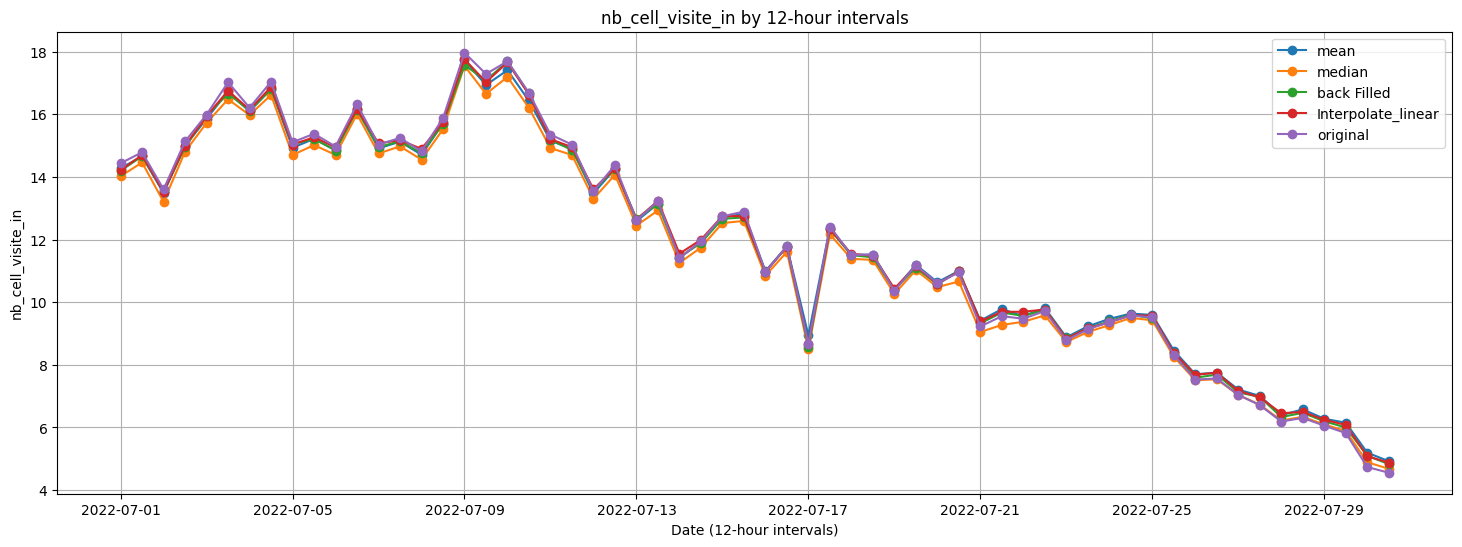

In [43]:
df = jul_22[['activation_date', 'co_id', col]]

# Convert activation_date to datetime format
df['activation_date'] = pd.to_datetime(df['activation_date'], format='%Y-%m-%d %H:%M:%S')
df[col]=df[col].fillna(method="bfill")
# Set start and end dates
start_date = pd.to_datetime('2022-07-01 00:00:00')
end_date = pd.to_datetime('2022-07-30 23:59:59')

# Filter data for the specified range
zoom_range = df[(df['activation_date'] >= start_date) & (df['activation_date'] <= end_date)]

# Resample data to 12-hour intervals
resampled_data = zoom_range.resample('12H', on='activation_date').mean()

# Plot the data
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(resampled_data_mean.index, resampled_data_mean[col], marker='o', linestyle='-', label="mean")
ax.plot(resampled_data_median.index, resampled_data_median[col], marker='o', linestyle='-', label="median")
ax.plot(resampled_data.index, resampled_data[col], marker='o', linestyle='-', label="back Filled")
ax.plot(resampled_data_interpolate.index, resampled_data_interpolate[col], marker='o', linestyle='-', label="Interpolate_linear")
#ax.plot(resampled_data_RA.index, resampled_data_RA[col], marker='o', linestyle='-', label="Rolling Average")
ax.plot(resampled_data_normal.index, resampled_data_normal[col], marker='o', linestyle='-', label="original")
#ax.plot(resampled_data_interpolate_poly.index, resampled_data_interpolate_poly[col], marker='o', linestyle='-', label="polynomial")

plt.xlabel('Date (12-hour intervals)')
plt.ylabel(f'{col}')
plt.title(f'{col} by 12-hour intervals')
plt.legend()
plt.grid(True)
plt.show()

In [46]:
#function to drop the row where missing values count doesnt exceed 5
def drop_columns_less_than_5(data):
    for df in data:
      for col in df:
          if df[col].isna().sum() < 5:
              #drop the rows containing nan values for that columns
              df.dropna(subset=[col], inplace=True)
drop_columns_less_than_5(dfs)

In [44]:
#use bfill for nbr_actif, flag_churn, and nbr_contrat
for df in dfs:
  df['nbr_actif']=df['nbr_actif'].fillna(method="bfill")
  df['flag_churn']=df['flag_churn'].fillna(method="bfill")
  df['nbr_contrat']=df['nbr_contrat'].fillna(method="bfill")

<ipython-input-44-f264892d40fa>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  jul_22['nbr_actif']=jul_22['nbr_actif'].fillna(method="bfill")
<ipython-input-44-f264892d40fa>:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  jul_22['flag_churn']=jul_22['flag_churn'].fillna(method="bfill")
<ipython-input-44-f264892d40fa>:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  jul_22['nbr_contrat']=jul_22['nbr_contrat'].fillna(method="bfill")


In [ ]:
for df in dfs :
  #fill with mean
  df['total_nb_recharge']=df['total_nb_recharge'].fillna(df['total_nb_recharge'].mean())
  df['total_u_data']=df['total_u_data'].fillna(df['total_u_data'].mean())
  df['total_u_out']=df['total_u_out'].fillna(df['total_u_out'].mean())
  #fill with median
  df['total_u_in']=df['total_u_in'].fillna(df['total_u_in'].median())
  #fill with Linear Inter
  df['total_rev_option']=df['total_rev_option'].interpolate(method='linear')
  df['nb_cont_out']=df['nb_cont_out'].interpolate(method='linear')
  df['nb_cont_in']=df['nb_cont_in'].interpolate(method='linear')
  df['nb_cell_visite_out']=df['nb_cell_visite_out'].interpolate(method='linear')
  #fill with polynomial
  df['total_rechage']=df['total_rechage'].interpolate(method='polynomial', order=5)
  df['usage_op3']=df['usage_op3'].interpolate(method='polynomial', order=3)
  #fill with bfill
  df['nb_cell_visite_in']=df['nb_cell_visite_in'].fillna(method='bfill')

### Label Encoding


In [ ]:
#Label encode entity_type_name
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for df in dfs:
    df['entity_type_name'] = le.fit_transform(df['entity_type_name'])

In [ ]:
#Label encode gouvernorat
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for df in dfs:
    df['gouvernorat'] = le.fit_transform(df['gouvernorat'])

Note : data is ready for scaling and Analysis ,PCA, clustering and Interpretations